In [2]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from scipy.signal import medfilt
import matplotlib.pyplot as plt

In [ ]:
def ssim_diff(frame1, frame2):
  gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
  score, _ = ssim(gray1, gray2, full=True)
  return 1.0 - score

45 - ssim_diff

result: Смены сцен (SSIM): [190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 210, 218, 219, 220, 221, 222, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247]

work_time - 1 min

In [ ]:
def gaus_ssim_diff(frame1, frame2):
  gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

  gray1 = cv2.GaussianBlur(gray1, (3, 3), 0)
  gray2 = cv2.GaussianBlur(gray2, (3, 3), 0)

  score, _ = ssim(gray1, gray2, full=True)
  return 1.0 - score

44 - gaus_ssim_diff

result: Смены сцен (SSIM): [190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 210, 218, 219, 220, 221, 222, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246]

work_time: 1 min

In [ ]:
def resize_ssim_diff(frame1, frame2):
  frame1 = cv2.resize(frame1, (0,0), fx=0.5, fy=0.5)
  frame2 = cv2.resize(frame2, (0,0), fx=0.5, fy=0.5)

  gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

  score, _ = ssim(gray1, gray2, full=True)
  return 1.0 - score

19 - resize_ssim_diff

result: Смены сцен (SSIM): [190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 209, 210, 222, 245, 246]

work_time: 20s

In [8]:
def preproccessing_ssim_frames(frame):
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  gray = cv2.resize(gray, (0,0), fx=0.5, fy=0.5)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)
  return gray

In [ ]:
def modern_ssim_diff(frame1, frame2):
  gray1 = preproccessing_ssim_frames(frame1)
  gray2 = preproccessing_ssim_frames(frame2)

  score, _ = ssim(gray1, gray2, full=True)
  return 1.0 - score

17 - modern_ssim_diff

resut: Смены сцен (SSIM): [191, 192, 193, 194, 195, 206, 207, 208, 209, 210, 218, 219, 220, 221, 222, 245, 246]

work_time: 18s

In [9]:
def gradient_ssim_detect(frame1, frame2, prev_ssim=None, win_size=3):
  gray1 = preproccessing_ssim_frames(frame1)
  gray2 = preproccessing_ssim_frames(frame2)

  if win_size < 3:
    win_size = 3

  score, _ = ssim(gray1, gray2, win_size=win_size, full=True, data_range=255)
  current_ssim = score

  if prev_ssim is None:
    return 0.0, current_ssim

  gradient = prev_ssim - current_ssim
  return gradient, current_ssim

27 - gradient_ssim_detect

result: Смены сцен (SSIM): [2, 3, 4, 5, 6, 46, 81, 131, 133, 134, 139, 140, 142, 206, 207, 245, 246, 256, 258, 259, 331, 332, 333, 334, 335, 336, 355]

work_time: 17s

In [ ]:
def detect_scene(video_path, threshold=2.0):
  cap = cv2.VideoCapture(video_path)
  prev_frame = None
  diffs = []
  frameidx = 0

  while cap.isOpened():
    ref, frame = cap.read()
    if not ref:
      break
    if prev_frame is not None:
      d = modern_ssim_diff(prev_frame, frame)
      diffs.append(d)
    prev_frame = frame.copy()
  cap.release()

  diffs = np.array(diffs)
  diffs_smoothed = medfilt(diffs, kernel_size=5)
  mean = np.mean(diffs_smoothed)
  std = np.std(diffs_smoothed)
  threshold_new = mean + threshold * std

  scene_changes = []
  for i, d in enumerate(diffs_smoothed):
    if d > threshold_new:
      scene_changes.append(i + 2)
  return scene_changes, diffs

In [4]:
def merge_close_changes(changes, max_gap=3):
        if not changes:
            return []
        merged = [changes[0]]
        for c in changes[1:]:
            if c - merged[-1] <= max_gap:
                continue
            else:
                merged.append(c)
        return merged

In [14]:
def detect_scene_with_grad(video_path, threshold=2.0):
    cap = cv2.VideoCapture(video_path)
    prev_frame = None
    diffs = []
    ssim_values = []  # будем хранить текущие SSIM для градиента
    frameidx = 0

    while cap.isOpened():
        ref, frame = cap.read()
        if not ref:
            break

        if prev_frame is not None:
            grad, curr_ssim = gradient_ssim_detect(prev_frame, frame, ssim_values[-1] if ssim_values else None)
            diffs.append(grad)
            ssim_values.append(curr_ssim)
        else:
            ssim_values.append(1.0)  # начальное значение

        prev_frame = frame.copy()

    cap.release()

    diffs = np.array(diffs)
    # Применяем медианный фильтр к градиенту
    diffs_smoothed = medfilt(diffs, kernel_size=5)

    # Адаптивный порог по скользящему окну
    def adaptive_threshold(signal, window=50, k=2.0):
        threshold = np.zeros_like(signal)
        half = window // 2
        for i in range(len(signal)):
            start = max(0, i - half)
            end = min(len(signal), i + half + 1)
            local_mean = np.mean(signal[start:end])
            local_std = np.std(signal[start:end])
            threshold[i] = local_mean + k * local_std
        return threshold

    threshold_curve = adaptive_threshold(diffs_smoothed, window=100, k=1.5)

    scene_changes = []
    for i, (d, thr) in enumerate(zip(diffs_smoothed, threshold_curve)):
        if d > thr:
            scene_changes.append(i + 2)

    # Объединяем близкие кадры

    scene_changes = merge_close_changes(scene_changes, max_gap=9)

    return scene_changes, diffs

In [15]:
scene_changes, diffs = detect_scene_with_grad('/content/drive/MyDrive/practical_data/man_in_costume.mp4', threshold=2.0)
print("Смены сцен (SSIM):", scene_changes)

Смены сцен (SSIM): [2, 46, 81, 131, 142, 206, 245, 256, 331, 355]


In [12]:
def show_frame_at(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    if ret:
        # Конвертируем BGR → RGB (потому что OpenCV использует BGR, а matplotlib — RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 6))
        plt.imshow(frame_rgb)
        plt.title(f"Кадр {frame_num}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Кадр {frame_num} не найден")
    cap.release()

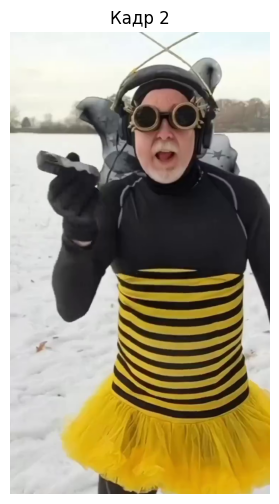

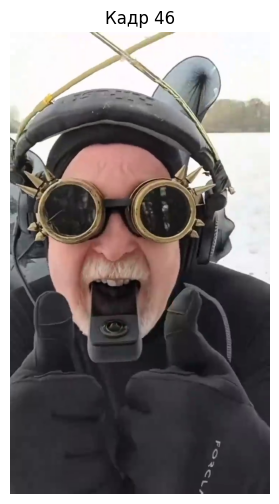

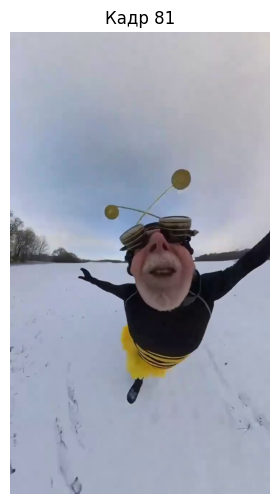

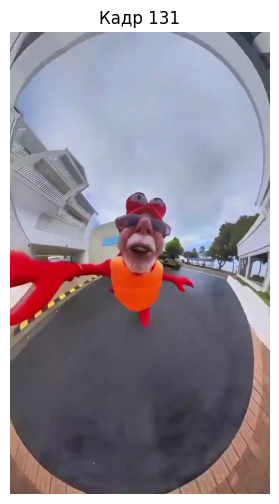

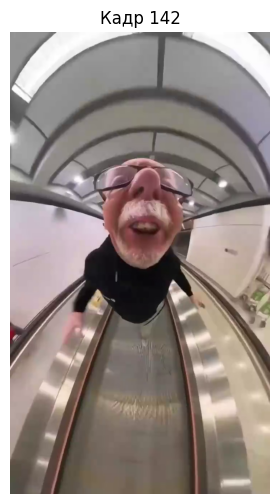

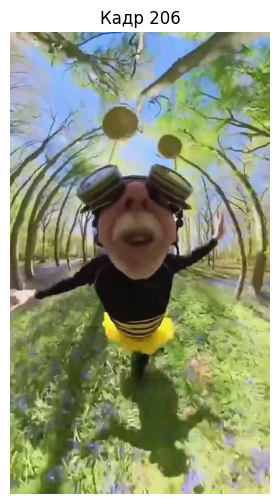

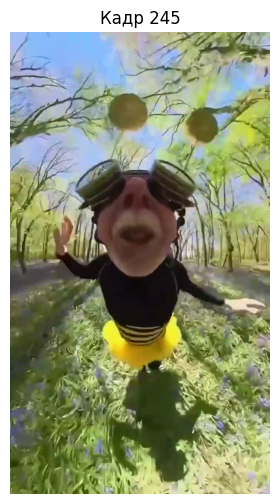

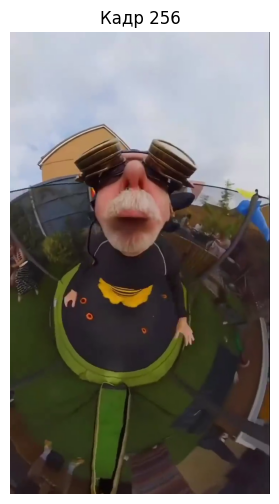

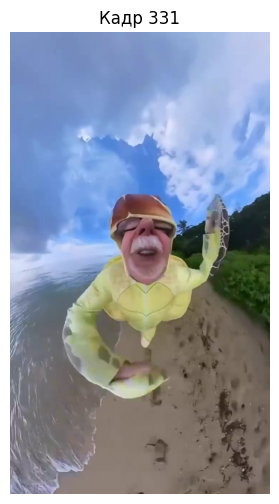

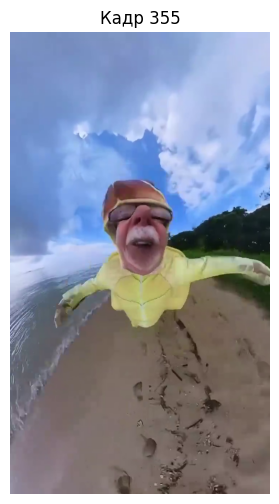

In [16]:
for frame in scene_changes:
  show_frame_at('/content/drive/MyDrive/practical_data/man_in_costume.mp4', frame)

In [1]:
len(scene_changes)

NameError: name 'scene_changes' is not defined

In [ ]:
def seconds(frame_num, fps=30):
  second = frame_num / fps
  return second

In [ ]:
for frame in scene_changes:
  f = seconds(frame, fps=30)
  print(f'Кадр {frame} был на секунде {f:.2f}')